In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
# step1：导入数据
df = pd.read_csv(r'D:/ChinaBank.csv', parse_dates=['Date'], index_col='Date')
df.drop('Unnamed: 0',axis=1, inplace=True)
df = df.dropna()
df_train = df['2014-01-01':'2014-03-31']
df_test = df['2014-04-01':'2014-04-30']
print(df)

            Open  High   Low  Close      Volume
Date                                           
2014-01-02  2.62  2.62  2.59   2.61    41632500
2014-01-03  2.60  2.61  2.56   2.56    45517700
2014-01-06  2.57  2.57  2.50   2.53    68674700
2014-01-07  2.51  2.52  2.49   2.52    53293800
2014-01-08  2.51  2.54  2.49   2.51    69087900
...          ...   ...   ...    ...         ...
2015-04-24  4.71  4.73  4.60   4.66  1619024500
2015-04-27  4.66  4.82  4.66   4.81  1841766000
2015-04-28  4.83  5.29  4.81   5.06  4017962400
2015-04-29  5.00  5.01  4.85   4.97  1872648800
2015-04-30  4.96  4.96  4.83   4.84  1471072900

[345 rows x 5 columns]


In [63]:
norm = df
norm

,Open,High,Low,Close,Volume
Date,,,,,
2014-01-02,2.62,2.62,2.59,2.61,41632500
2014-01-03,2.60,2.61,2.56,2.56,45517700
2014-01-06,2.57,2.57,2.50,2.53,68674700
2014-01-07,2.51,2.52,2.49,2.52,53293800
2014-01-08,2.51,2.54,2.49,2.51,69087900
...,...,...,...,...,...
2015-04-24,4.71,4.73,4.60,4.66,1619024500
2015-04-27,4.66,4.82,4.66,4.81,1841766000
2015-04-28,4.83,5.29,4.81,5.06,4017962400


In [64]:
# svd分解
u, sigma, v = np.linalg.svd(norm, full_matrices=False)
u.shape

(345, 5)

In [65]:
# 求奇异值对角矩阵
sig = np.diag(sigma)
sig.shape

(5, 5)

In [66]:
# 求svd分解主成分
train_svd = np.dot(u, sig[:, :3])
train_svd.shape

(345, 3)

In [67]:
# 将分解后的做成pandas结构
df_svd = pd.DataFrame(train_svd, index=df.index, columns=list('123'))
df_svd

,1,2,3
Date,,,
2014-01-02,-4.163250e+07,5.015172,0.005069
2014-01-03,-4.551770e+07,4.941101,0.018380
2014-01-06,-6.867470e+07,4.747199,0.014765
2014-01-07,-5.329380e+07,4.757781,-0.007584
2014-01-08,-6.908790e+07,4.685100,-0.006688
...,...,...,...
2015-04-24,-1.619025e+09,1.382966,0.076483
2015-04-27,-1.841766e+09,0.411843,-0.053105
2015-04-28,-4.017962e+09,-9.776669,-0.103082


In [68]:
# 训练数据svd分解后还原
restore = np.dot(df_svd, v[:3, :])
restore = pd.DataFrame(restore, index=df.index[:], columns=df.columns + '_restore')
restore

,Open_restore,High_restore,Low_restore,Close_restore,Volume_restore
Date,,,,,
2014-01-02,2.615456,2.621435,2.596221,2.606918,4.163250e+07
2014-01-03,2.596873,2.590025,2.572073,2.571178,4.551770e+07
2014-01-06,2.554069,2.552157,2.530312,2.533705,6.867470e+07
2014-01-07,2.506638,2.525431,2.492978,2.514947,5.329380e+07
2014-01-08,2.509526,2.528497,2.494980,2.517071,6.908790e+07
...,...,...,...,...,...
2015-04-24,4.706875,4.753899,4.595761,4.643345,1.619025e+09
2015-04-27,4.678626,4.867123,4.614797,4.789008,1.841766e+09
2015-04-28,4.872444,5.254474,4.760116,5.102825,4.017962e+09


In [69]:
# step2：检验不同序列之间存在互相影响
maxlag=12
test='ssr_chi2test'
variables=df_svd.columns
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_svd, variables = df_svd.columns)

,1_x,2_x,3_x
1_y,1.0,0.0000,0.0
2_y,0.0,1.0000,0.0
3_y,0.0,0.0001,1.0


In [70]:
# step3：ADF测试，检验单个变量是否平稳
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'        Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")
for name, column in df_svd.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

        Augmented Dickey-Fuller Test on "1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.5197
 No. Lags Chosen       = 15
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.8881. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


        Augmented Dickey-Fuller Test on "2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.5085
 No. Lags Chosen       = 15
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.5293. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


        Augmented Dickey-Fuller Test on "3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit r

In [71]:
# step4: 协整检验，检验多变量平稳性
def cointegration_test(df, alpha=0.05): 
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df_svd)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
1      ::  36.66     > 24.2761   =>   True
2      ::  14.59     > 12.3212   =>   True
3      ::  2.33      > 4.1296    =>   False


In [72]:
# step5：划分训练集和测试集
df_train_svd, df_test_svd = df_svd[0:62], df_svd[62:84]

In [73]:
# step6：使用VAR之间，先差分处理使单个变量变得平稳
df_differenced = df_train_svd.diff().dropna()
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

        Augmented Dickey-Fuller Test on "1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.9144
 No. Lags Chosen       = 2
 Critical value 1%     = -3.548
 Critical value 5%     = -2.913
 Critical value 10%    = -2.594
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


        Augmented Dickey-Fuller Test on "2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.5993
 No. Lags Chosen       = 2
 Critical value 1%     = -3.548
 Critical value 5%     = -2.913
 Critical value 10%    = -2.594
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


        Augmented Dickey-Fuller Test on "3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.

In [74]:
# step7：选择模型阶数并训练，选取阶数
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9,10]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  17.697666663964824
BIC :  18.116535576409245
FPE :  48557578.7190534
HQIC:  17.861509322536406 

Lag Order = 2
AIC :  17.48541451871783
BIC :  18.224876998752066
FPE :  39380573.02640469
HQIC:  17.774070722414027 

Lag Order = 3
AIC :  17.543274147973925
BIC :  18.609020532739315
FPE :  42022320.357062235
HQIC:  17.95840388958675 

Lag Order = 4
AIC :  17.790510813869776
BIC :  19.188387997124995
FPE :  54570641.00858228
HQIC:  18.333773521855004 

Lag Order = 5
AIC :  17.791961614059083
BIC :  19.527977348974925
FPE :  56009725.008025765
HQIC:  18.465011243145213 

Lag Order = 6
AIC :  18.044050961996337
BIC :  20.12437808123726
FPE :  74997261.20095748
HQIC:  18.848530263905786 

Lag Order = 7
AIC :  18.087587843279003
BIC :  20.51856834463534
FPE :  83314712.42540269
HQIC:  19.02512168975438 

Lag Order = 8
AIC :  18.01848840566885
BIC :  20.80663733994072
FPE :  85310890.39209943
HQIC:  19.090676014700662 

Lag Order = 9
AIC :  18.116320752383015
BIC :  21.2683

In [75]:
# 选择合适的阶数拟合模型
model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 17, Nov, 2022
Time:                     09:54:06
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    20.8066
Nobs:                     53.0000    HQIC:                   19.0907
Log likelihood:          -628.101    FPE:                8.53109e+07
AIC:                      18.0185    Det(Omega_mle):     2.67638e+07
--------------------------------------------------------------------
Results for equation 1
              coefficient        std. error           t-stat            prob
----------------------------------------------------------------------------
const     -1478017.747556    3413122.933197           -0.433           0.665
L1.1             0.297025          1.100203            0.270           0.787
L1.2    -140010764.853606  210924903.866330           -0.664           0.507
L1.

In [76]:
# step8：检验残差项中是否还存在相关性，这一步的目的是确保模型已经解释了数据中所有的方差和模式
out = durbin_watson(model_fitted.resid)
for col, val in zip(df_svd.columns, out):
    print(col, ':', round(val, 2))  # 检验值越接近2，说明模型越好

1 : 1.95
2 : 1.99
3 : 2.07


In [77]:
# step9：预测
lag_order = model_fitted.k_ar
print(lag_order)
forecast_input = df_differenced.values[-lag_order:]
print(forecast_input)
fc = model_fitted.forecast(y=forecast_input, steps=22)
df_forecast = pd.DataFrame(fc, index=df_test.index[:], columns=df_svd.columns + '_2d')
df_forecast

8
[[ 1.14550000e+06  5.62823722e-03 -1.04207595e-03]
 [-5.04610000e+07 -1.88222539e-01 -5.65776128e-02]
 [ 3.51599000e+07  2.52933086e-01  5.83623884e-02]
 [ 1.97571000e+07  9.21747370e-02 -2.06130778e-03]
 [-3.39710000e+06 -6.72177647e-03 -3.38437141e-04]
 [-2.69441000e+07 -8.75268984e-02 -7.35429685e-03]
 [-4.04409000e+07 -1.59012013e-01  1.80585028e-03]
 [ 5.08218000e+07  2.50059653e-01  4.31703304e-03]]


,1_2d,2_2d,3_2d
Date,,,
2014-04-01,-1.169983e+07,-0.042831,-0.008119
2014-04-02,-3.650825e+07,-0.171301,-0.012972
2014-04-03,2.625822e+07,0.121276,0.017499
2014-04-04,3.016208e+07,0.060232,0.034253
2014-04-07,-2.130283e+07,-0.124169,-0.055989
2014-04-08,-2.308687e+07,-0.062787,-0.004432
2014-04-09,1.804223e+07,0.132848,0.016614
2014-04-10,2.344935e+07,0.111253,0.020441
2014-04-11,-1.932155e+07,-0.083945,-0.016464


In [78]:
# step10：将差分后的值还原为原数据
def invert_transformation(df_train, df_forecast):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns: 
        # 写一个长度为6的数列，用纸笔写出差分的计算过程，可以帮助理解下面这两行还原过程
#         df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_2d'].cumsum()
    return df_fc
df_results = invert_transformation(df_train_svd[:], df_forecast)  
# df_results = df_results.loc[:, ['Open_forecast', 'High_forecast', 'Low_forecast', 'Close_forecast',
#                    'Volume_forecast']]

df_results = df_results.loc[:, ['1_forecast', '2_forecast', '3_forecast']]

df_results

,1_forecast,2_forecast,3_forecast
Date,,,
2014-04-01,-5.421673e+07,4.907983,-0.016052
2014-04-02,-9.072498e+07,4.736682,-0.029024
2014-04-03,-6.446677e+07,4.857958,-0.011524
2014-04-04,-3.430468e+07,4.918191,0.022729
2014-04-07,-5.560751e+07,4.794022,-0.033260
2014-04-08,-7.869438e+07,4.731234,-0.037692
2014-04-09,-6.065215e+07,4.864083,-0.021078
2014-04-10,-3.720279e+07,4.975336,-0.000637
2014-04-11,-5.652435e+07,4.891391,-0.017101


In [79]:
# step11：将x2还原为原来的维度
df_res = np.dot(df_results, v[:3, :])
df_res = pd.DataFrame(df_res, index=df_test.index, columns=df_test.columns+'_forecast')
df_res

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Volume_forecast
Date,,,,,
2014-04-01,2.578361,2.605727,2.567774,2.597603,5.421673e+07
2014-04-02,2.573239,2.615699,2.566952,2.610253,9.072498e+07
2014-04-03,2.581468,2.605092,2.568651,2.595090,6.446677e+07
2014-04-04,2.560893,2.548933,2.534847,2.529308,3.430468e+07
2014-04-07,2.513118,2.557212,2.510064,2.554807,5.560751e+07
2014-04-08,2.535215,2.585244,2.533154,2.583219,7.869438e+07
2014-04-09,2.568751,2.601431,2.560117,2.594692,6.065215e+07
2014-04-10,2.580825,2.591986,2.564321,2.579621,3.720279e+07
2014-04-11,2.574998,2.603532,2.564796,2.595664,5.652435e+07


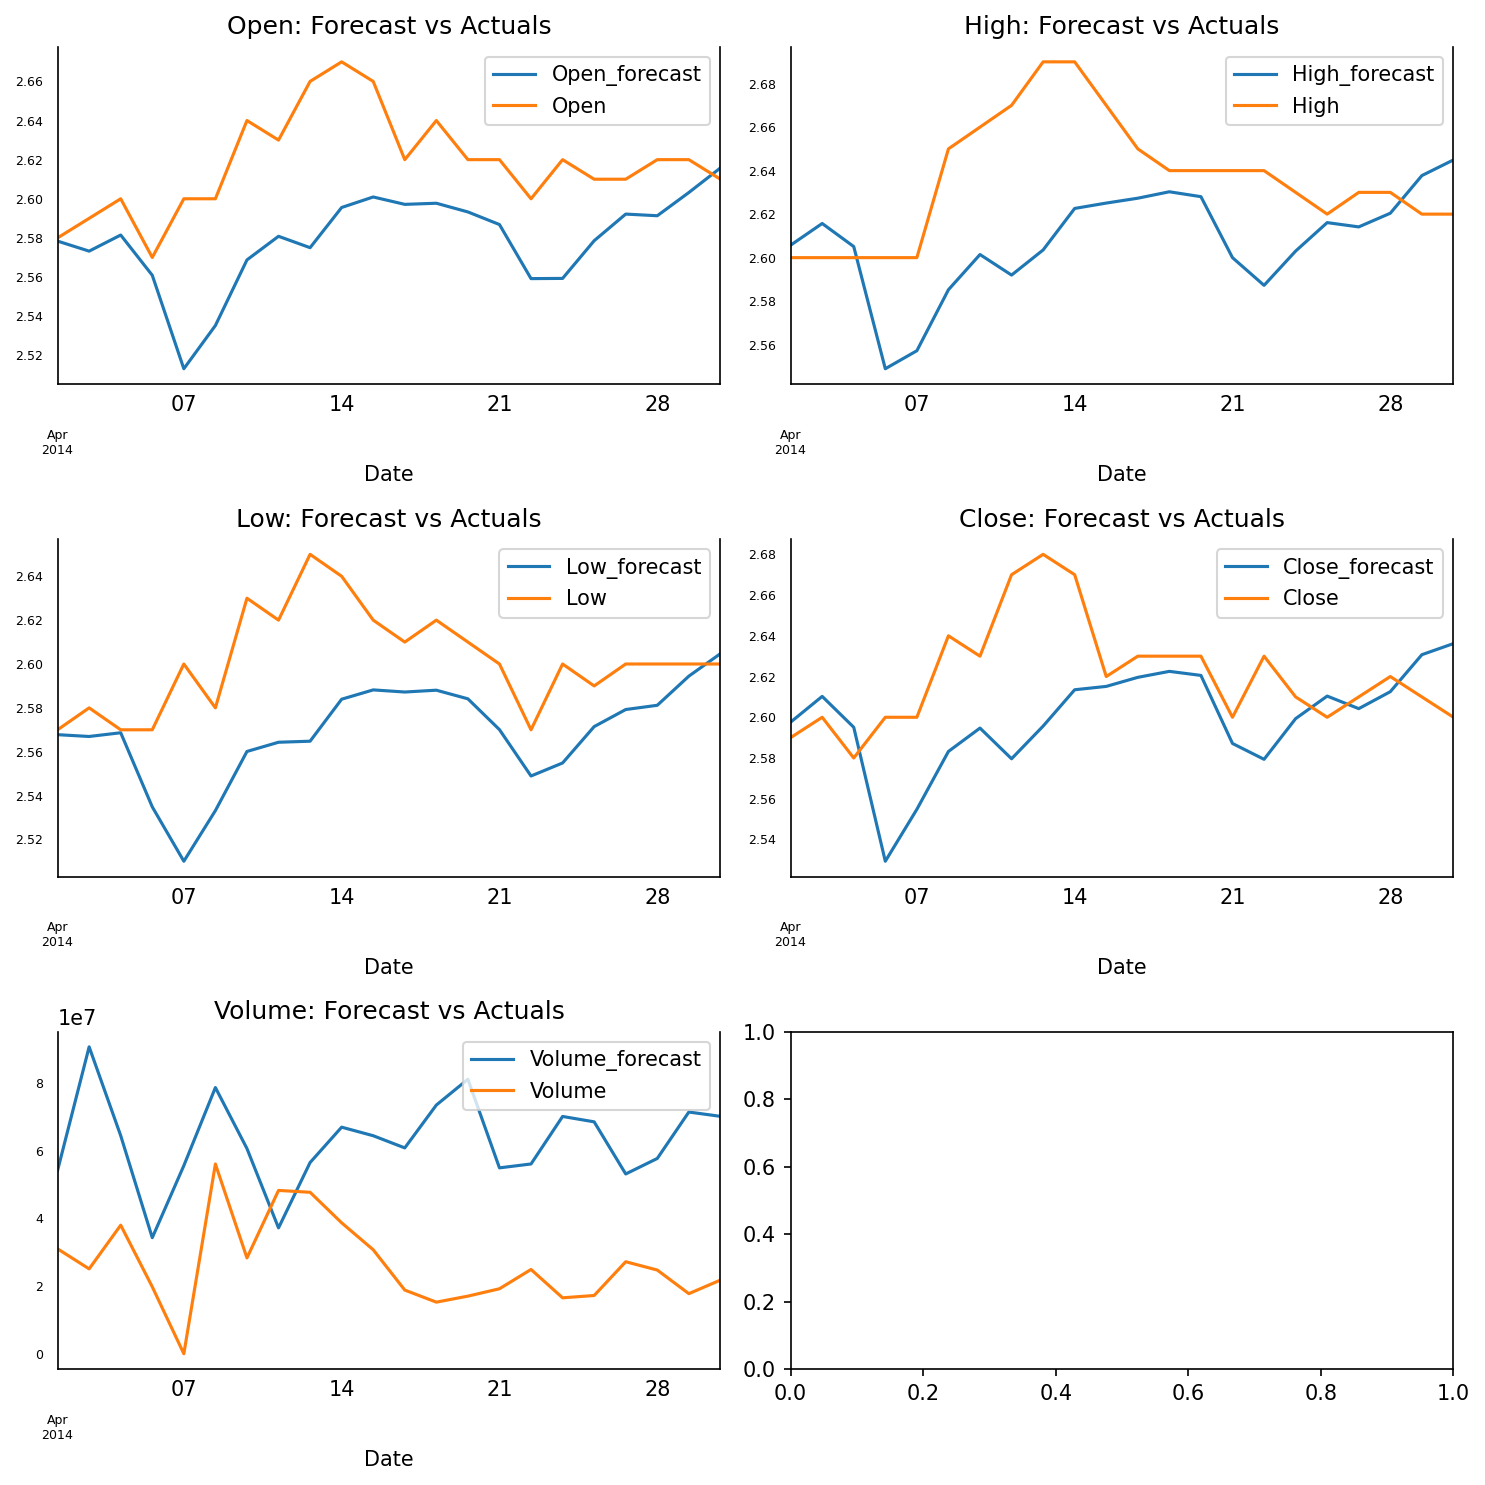

In [80]:
# step12：可视化对比
fig, axes = plt.subplots(nrows=int(len(df.columns)/2)+1, ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_res[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()